In this notebook we perform subclustering analysis of the tumor cells in the endometrial cancer (EC) patients.

From the previous clustering analysis of the whole dataset, the tumor cells generally form their own clusters for each patient. Here we will explore further the tumor cells by performing an additional clustering analysis separate from the other cell types.

Goals:
* Identify tumor cell subpopulations in EC patients. 
* Downstream in R: marker gene analysis, metacell analysis co-expression analysis

In [24]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm
import anndata
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')


In [3]:
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/')
data_dir = '/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/'
fig_dir = '/home/groups/singlecell/smorabito/analysis/SERPENTINE/figures/'


In [5]:
# re-load the processed dataset 
adata_full = sc.read_h5ad('{}SERPENTINE_PCA_annotated_14-05-24.h5ad'.format(data_dir))

## Subset the EC Tumor cells:

In [6]:
# subset the tumor cells only:
adata = adata_full[adata_full.obs.general_annot == 'Tumor'].copy()

# subset the cells from endometrial cancer patients
adata = adata[adata.obs['Tumor Type'] == 'Endometrial'].copy()

adata.shape

(43098, 36601)

## Subclustering analysis of the EC Tumor cells

Here we perform subclustering analysis of the EC tumor cells starting from the raw counts.

In [12]:
# reset .X as the counts matrix:
adata.X = adata.layers['counts'].copy()

In [13]:
# normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [14]:
# identify HVGs with default parameters
sc.pp.highly_variable_genes(adata)

In [15]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [16]:
sc.pp.neighbors(adata, use_rep = 'X_pca', n_neighbors=20, n_pcs=30, metric='cosine')

/home/groups/singlecell/smorabito/.conda/envs/serp-scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
sc.tl.umap(adata, min_dist=0.35, method='umap')

In [18]:
# clustering 
for res in [0.5, 1.0, 1.5, 2.0]:
    print(res)
    x = 'Tumor_leiden_' + str(res)
    sc.tl.leiden(adata, resolution=res)
    adata.obs[x] = adata.obs.leiden
    

0.5


/scratch_tmp/23675888/ipykernel_251080/2656131359.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res)


1.0
1.5
2.0


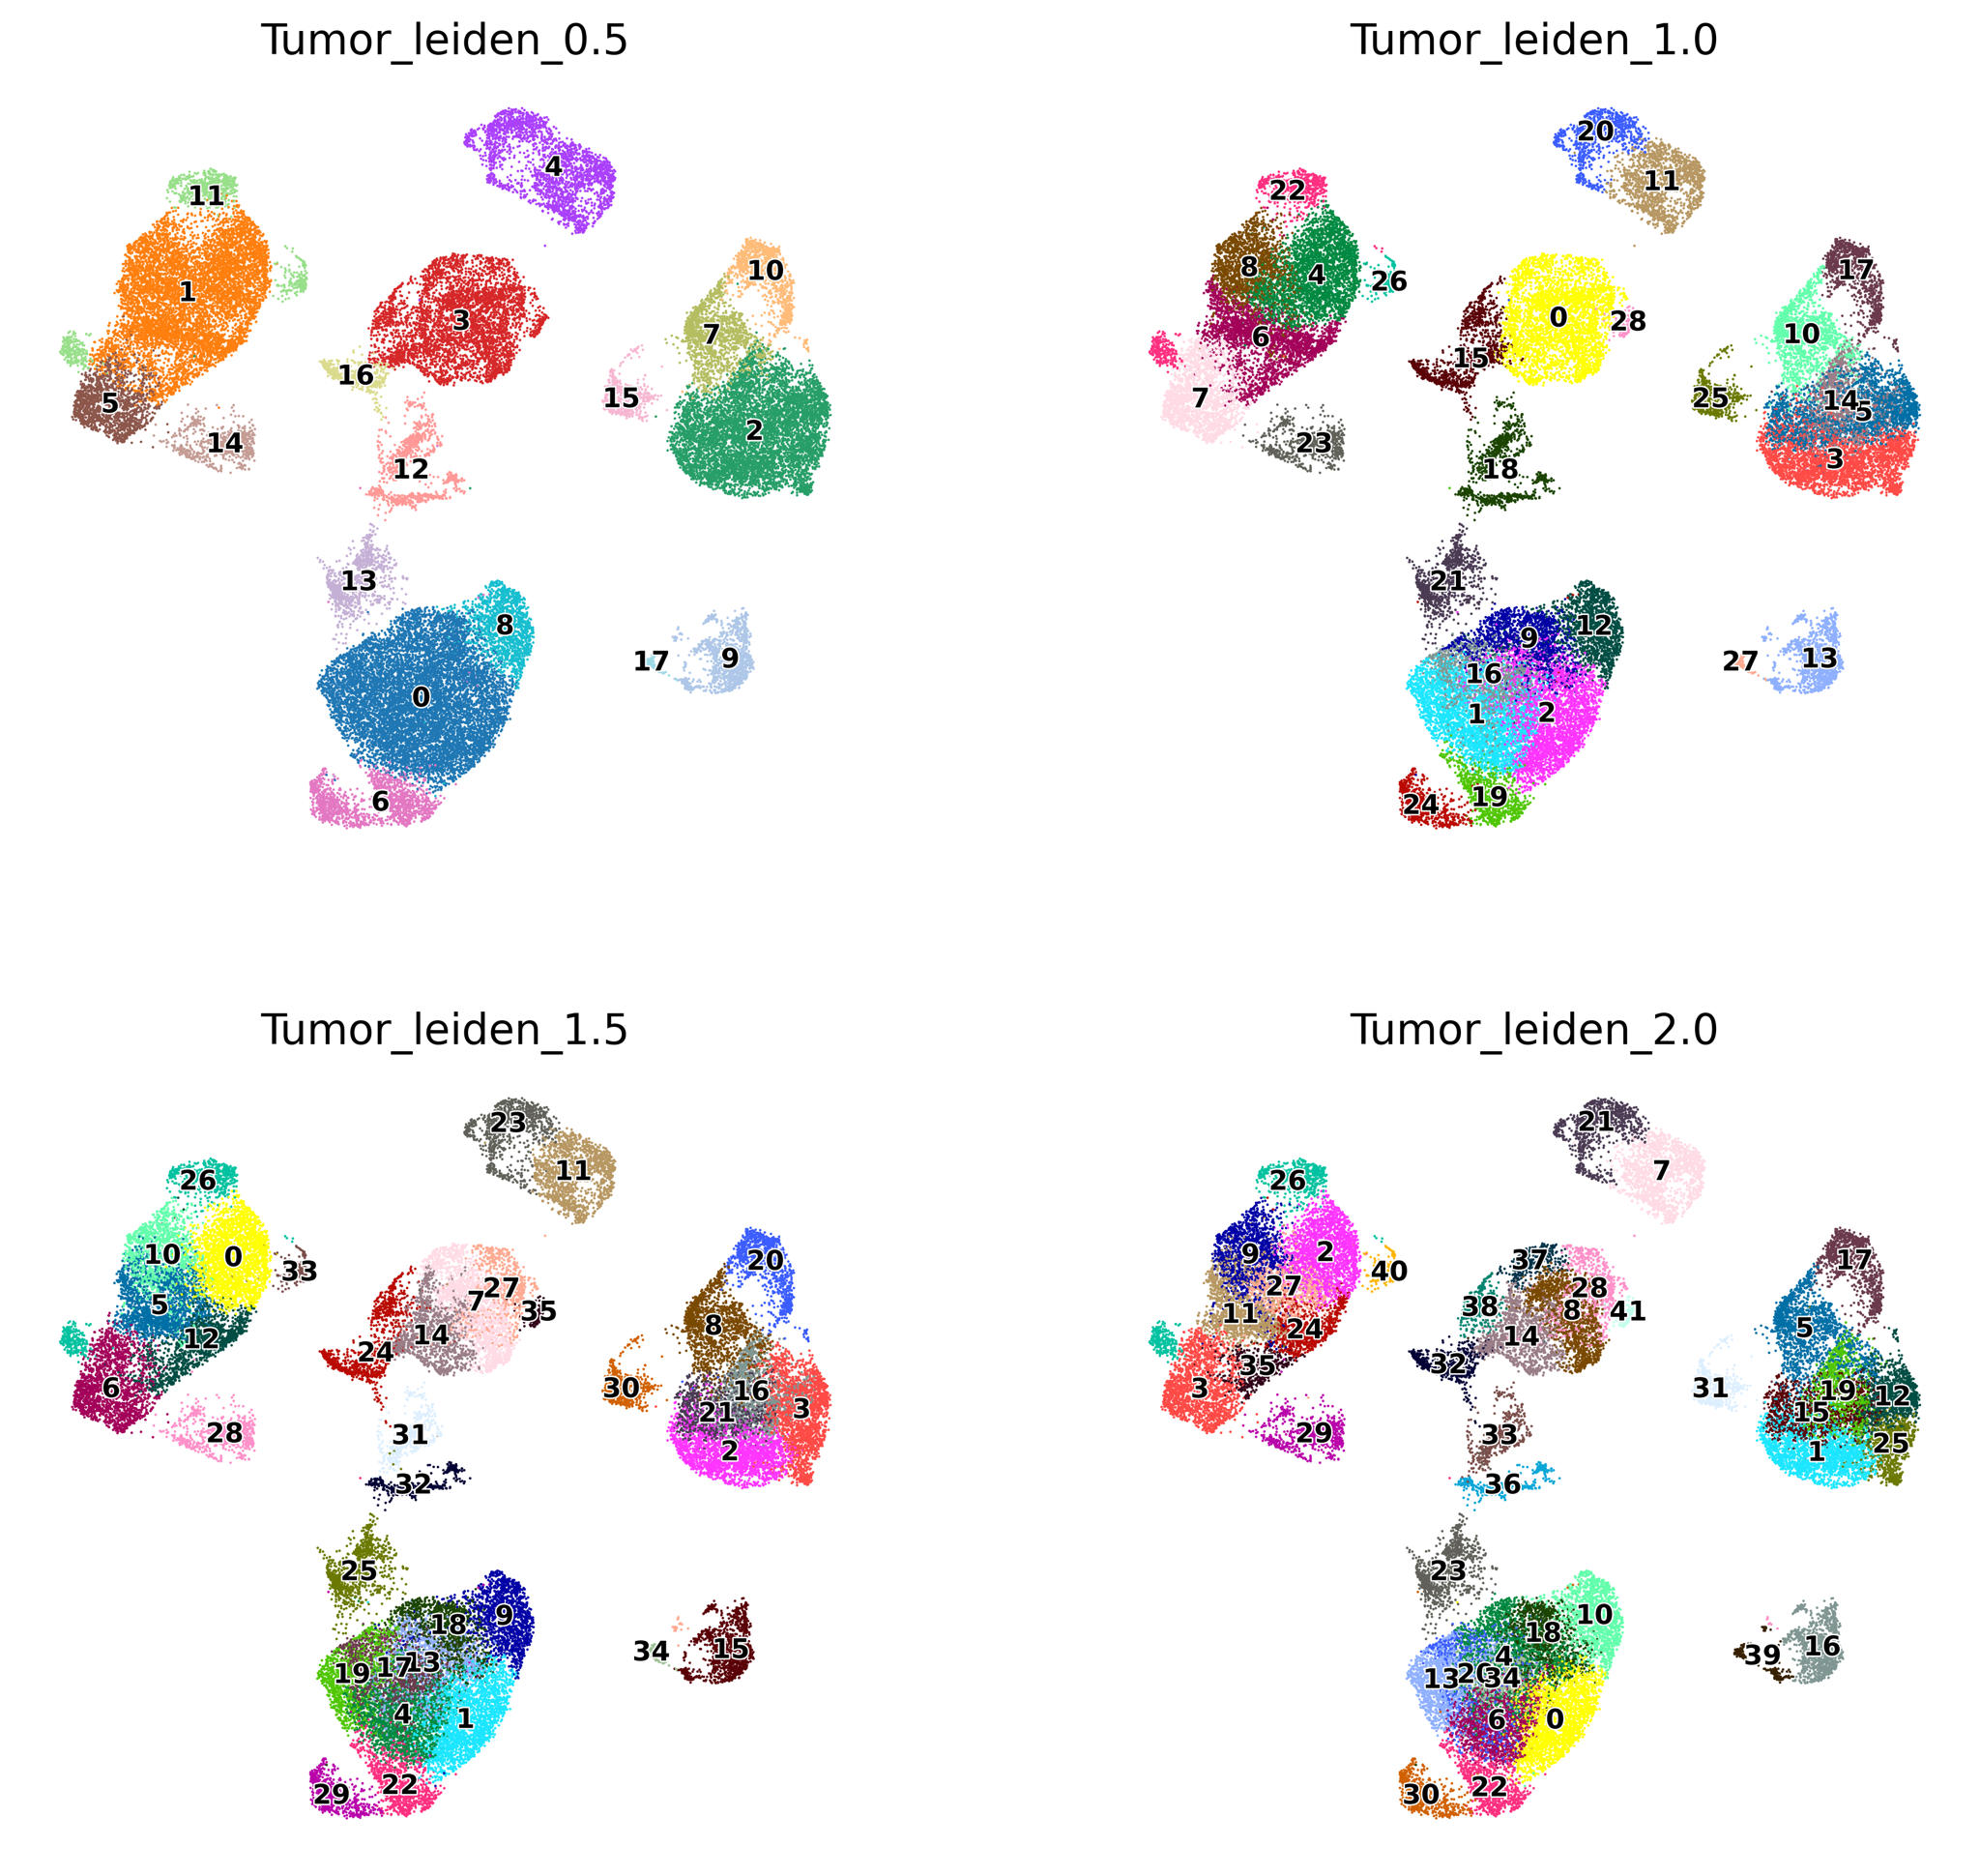

In [20]:
sc.settings.set_figure_params(dpi=200, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['Tumor_leiden_0.5', 'Tumor_leiden_1.0', 'Tumor_leiden_1.5', 'Tumor_leiden_2.0'],
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=2,
    save='_Tumor_leiden.pdf'
)

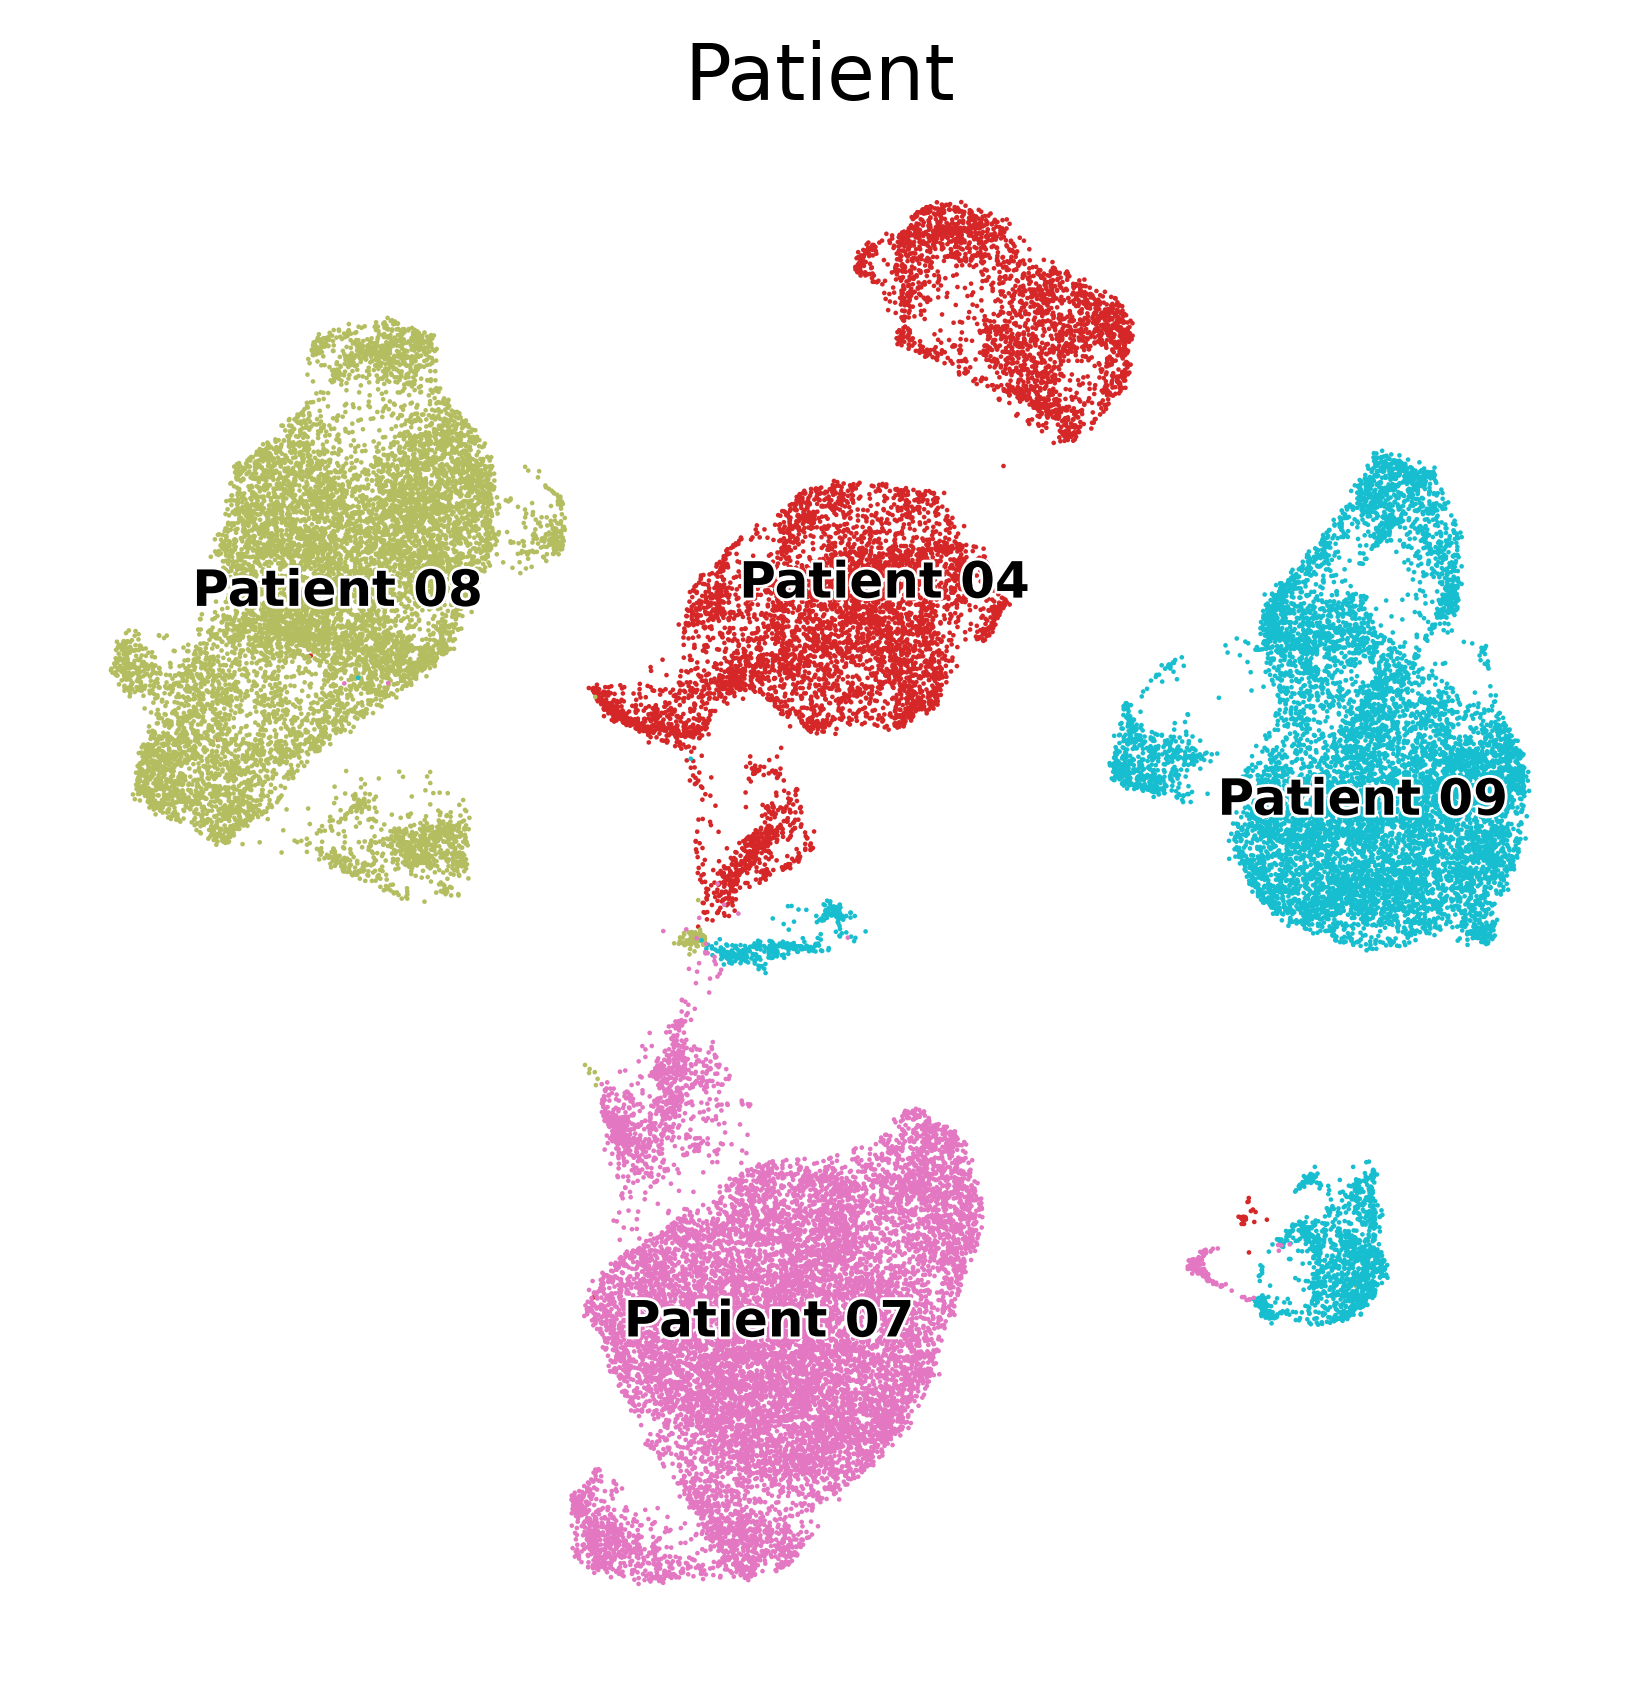

In [21]:
sc.settings.set_figure_params(dpi=200, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color='Patient',
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=1,
    save='_tumor_Patient_PCA.pdf'
)

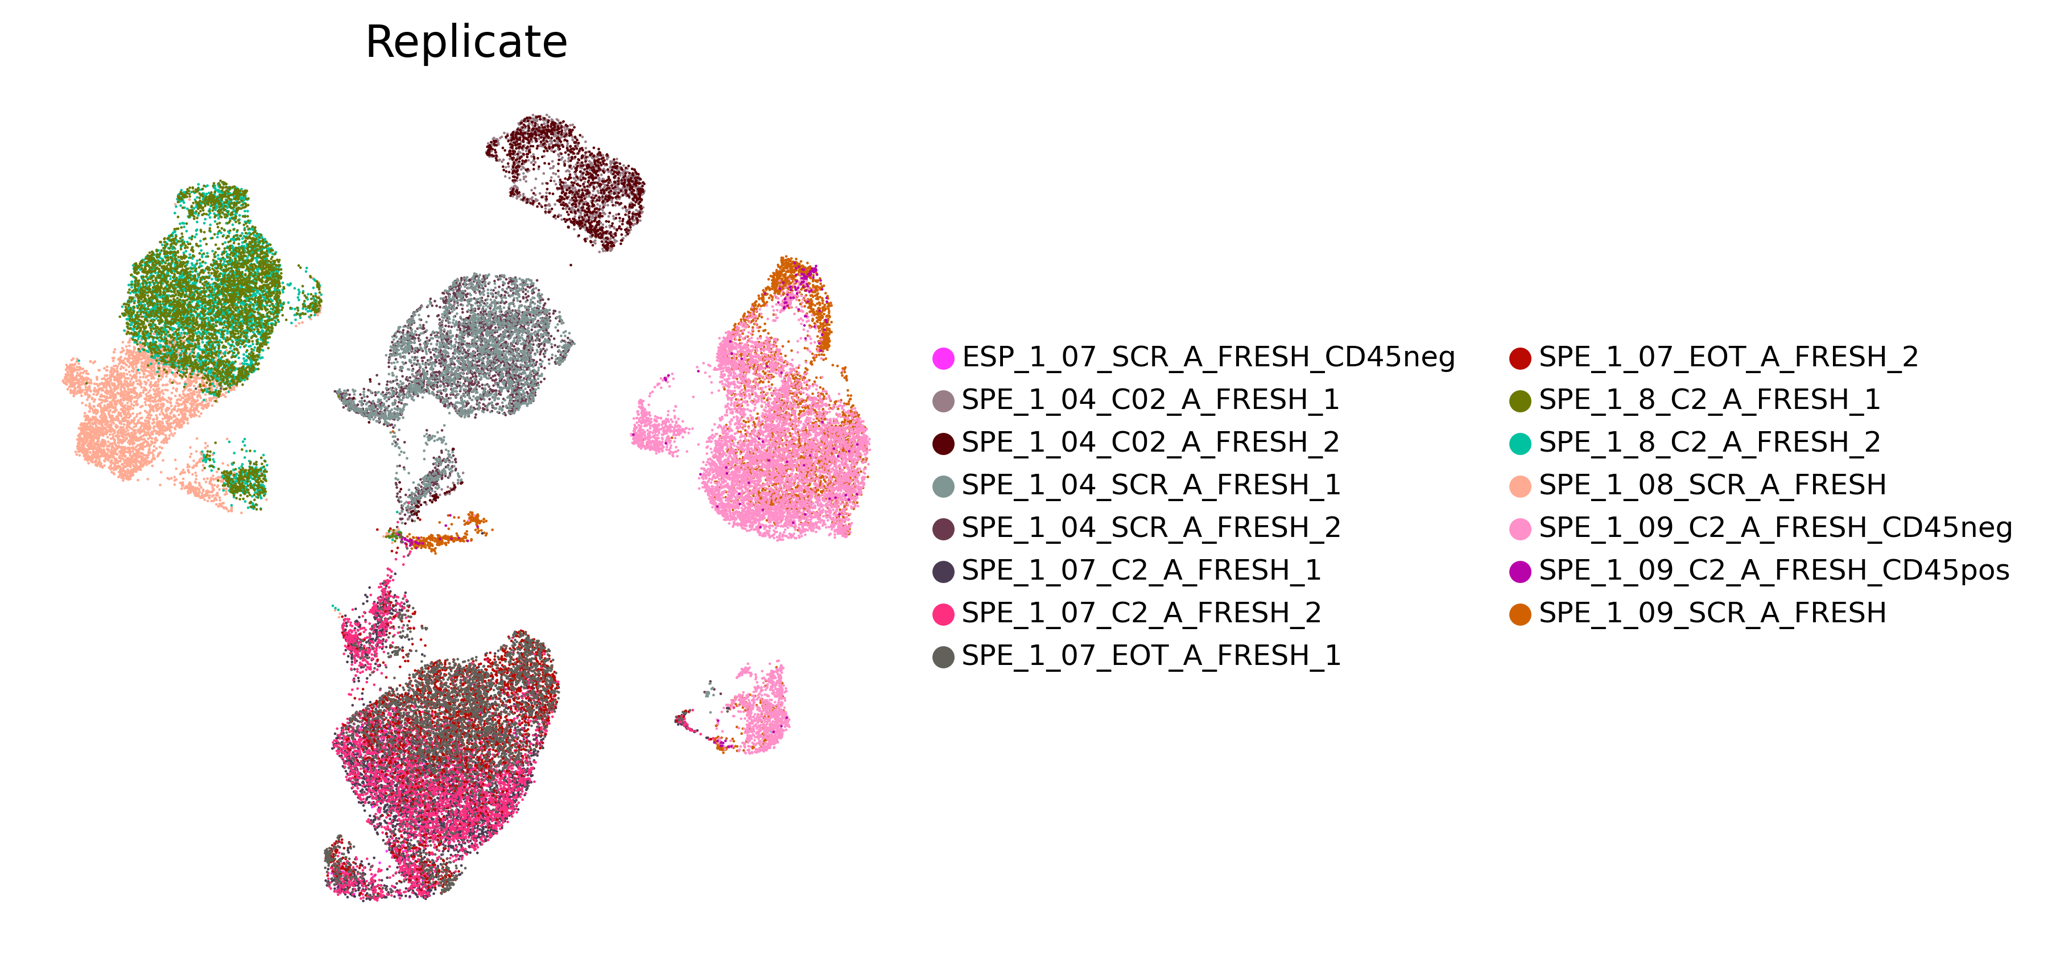

In [22]:
sc.settings.set_figure_params(dpi=200, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color='Replicate',
    frameon=False, 
   # legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=1,
    save='_tumor_Replicate_PCA.pdf'
)

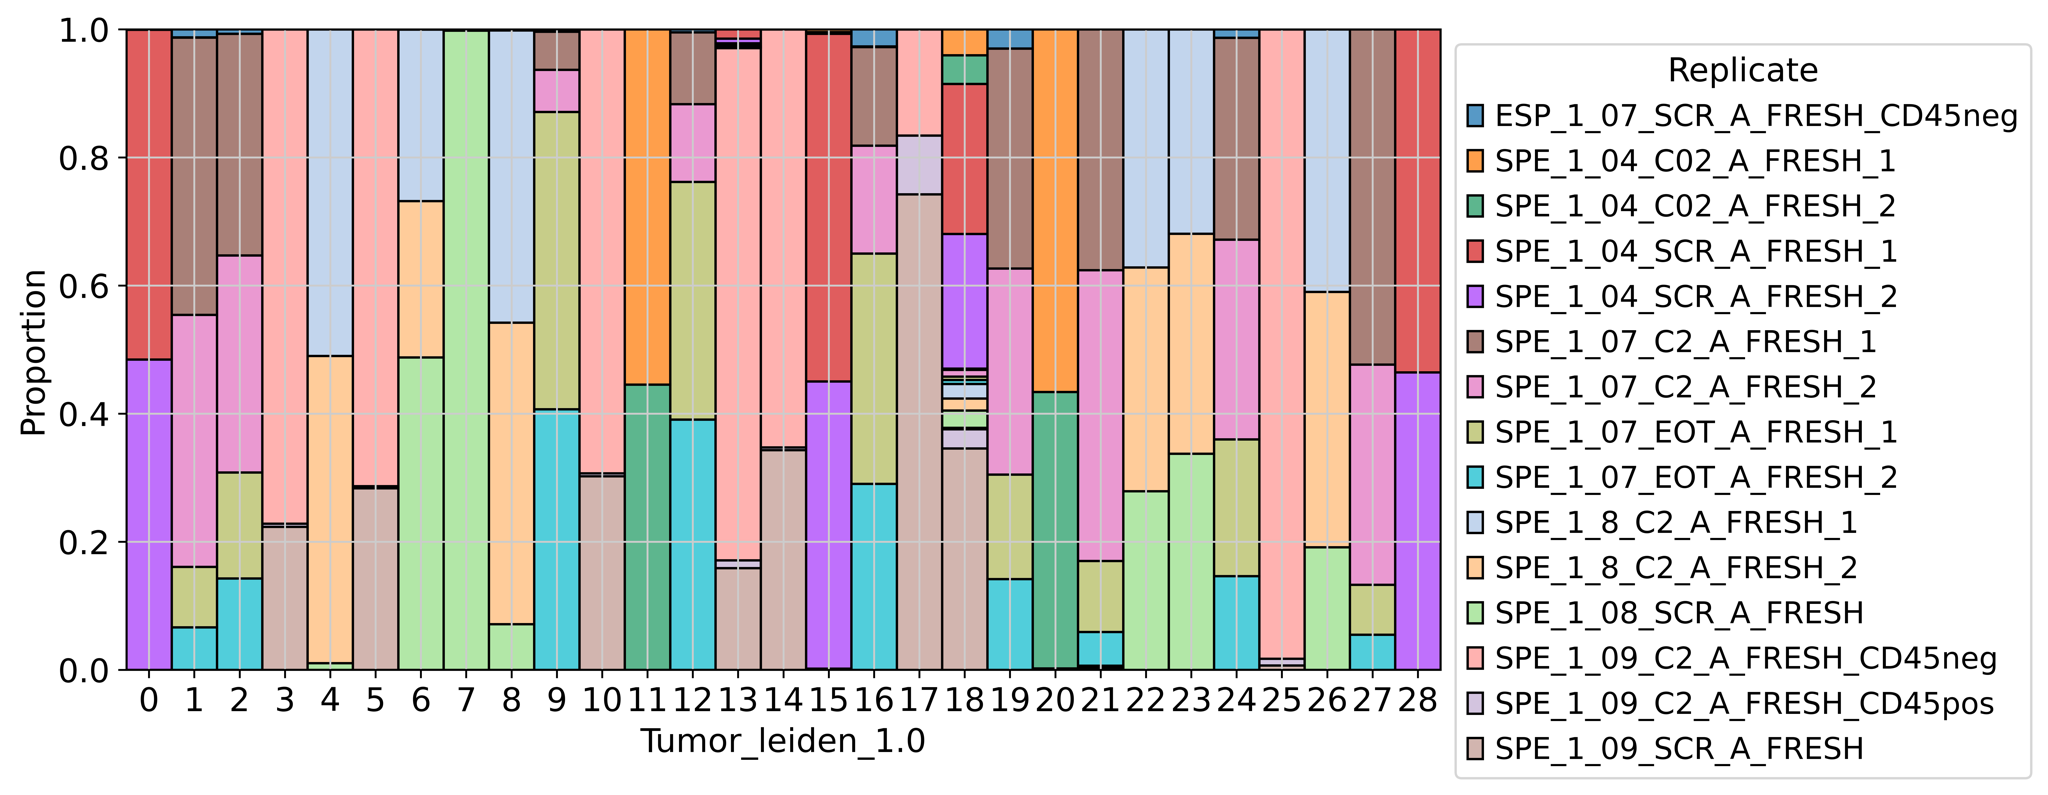

In [36]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(10,5), facecolor='white')
ax = sns.histplot(
    data = adata.obs,
    x = 'Tumor_leiden_1.0',
    hue = 'Replicate',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

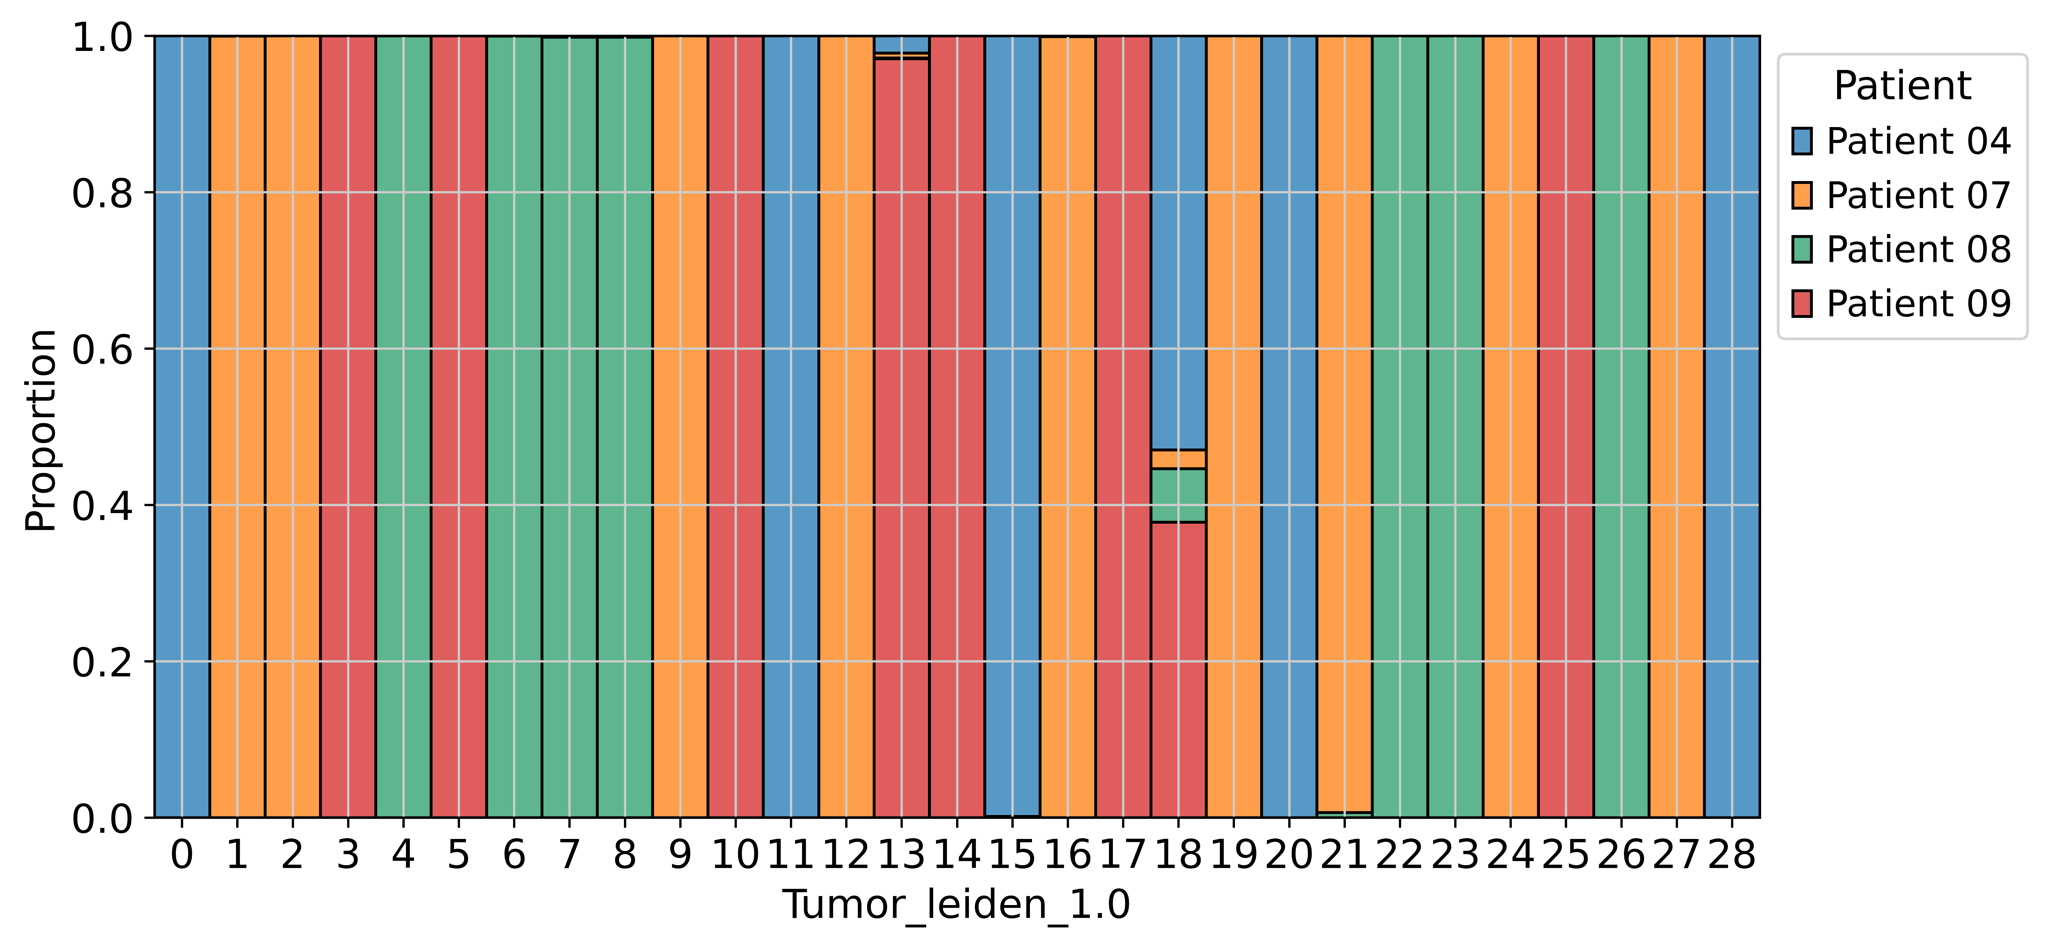

In [37]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(10,5), facecolor='white')
ax = sns.histplot(
    data = adata.obs,
    x = 'Tumor_leiden_1.0',
    hue = 'Patient',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Save the results

In [40]:
out_name = "EC_Tumor_29-05-24"

In [38]:
adata.write('{}SERPENTINE_PCA_{}.h5ad'.format(data_dir, out_name))

In [49]:
adata.obsm['X_umap'][:,0]

array([4.170043 , 1.2728107, 7.995777 , ..., 6.58916  , 5.3472223,
       1.4241778], dtype=float32)

In [50]:
# add umap coords to the obs table
adata.obs['UMAP_1'] = adata.obsm['X_umap'][:,0]
adata.obs['UMAP_2'] = adata.obsm['X_umap'][:,1]

# write the obs and var tables:
adata.obs.to_csv('{}/{}_cell_meta.csv'.format(data_dir, out_name))
adata.var.to_csv('{}/{}_gene_meta.csv'.format(data_dir, out_name))



In [43]:
# re-name harmony
pd.DataFrame(adata.obsm['X_pca']).to_csv('{}/{}_pca.csv'.format(data_dir, out_name))


In [44]:
X = adata.layers['counts']
X.shape

(43098, 36601)

In [45]:
# write counts mat
import scipy
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix

X = scipy.sparse.csr_matrix.transpose(X)
io.mmwrite('{}/{}_counts.mtx'.format(data_dir, out_name), X)